In [25]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [26]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2022, 12, 31)

In [27]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    column_name = ".".join(os.path.basename(filepath).split(".")[:-1])

    df.rename(columns = {"Adj Close": column_name}, inplace = True)
    return df

def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({'Date': pd.date_range(start, end, freq = 'D')})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on = "Date", how = "left")

    df.set_index("Date", inplace = True)
    return df

Data downloaded manually from the Yahoo Finance website.

In [28]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

<AxesSubplot: xlabel='Date'>

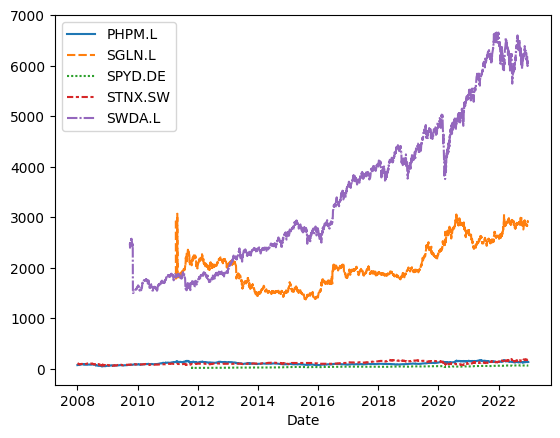

In [29]:
sns.lineplot(data = etf_df)

<AxesSubplot: xlabel='Date'>

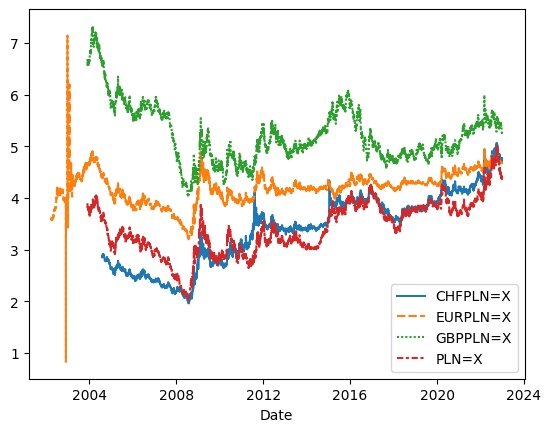

In [30]:
sns.lineplot(data = exchange_rates_df)

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions.

In [31]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1]
}

for column_name in etf_df.columns:
    etf_df[column_name] = etf_df[column_name] * exchange_rates_df[etf_currencies[column_name][0]] * etf_currencies[column_name][1]

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [32]:
etf_df.dropna(inplace = True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, let's write down the latest prices.

In [33]:
latest_prices = get_latest_prices(etf_df)

etf_df = etf_df.div(etf_df.iloc[0] / 100)

In [34]:
latest_prices

PHPM.L     586.651109
SGLN.L     152.883882
SPYD.DE    302.034633
STNX.SW    854.922003
SWDA.L     319.144446
Name: 2022-12-23 00:00:00, dtype: float64

In [35]:
etf_df

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
Date,,,,,
2011-10-14,100.000000,100.000000,100.000000,100.000000,100.000000
2011-10-17,99.424854,100.311243,99.948786,100.326435,99.247750
2011-10-18,99.193810,100.218232,101.354843,102.080533,100.849047
2011-10-19,99.778431,99.487012,100.938815,103.302874,101.127185
2011-10-20,96.689167,97.927457,100.452838,101.673715,100.003301
...,...,...,...,...,...
2022-12-19,144.741134,148.138956,380.341403,264.130341,386.204800
2022-12-20,147.663010,150.205653,377.569842,263.535363,384.796731
2022-12-21,146.104063,150.683401,383.493156,268.213853,392.060799


[Text(0.5, 1.0, 'Portfolio Components History'), Text(0, 0.5, 'Value (PLN)')]

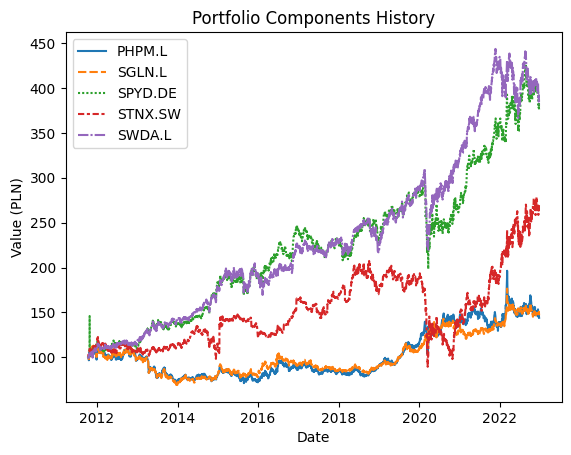

In [36]:
sns.lineplot(data = etf_df).set(title = 'Portfolio Components History', ylabel = 'Value (PLN)')

In [37]:
#Show the daily simple return
returns = etf_df.pct_change()
returns

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
Date,,,,,
2011-10-14,NaN,NaN,NaN,NaN,NaN
2011-10-17,-0.005751,0.003112,-0.000512,0.003264,-0.007523
2011-10-18,-0.002324,-0.000927,0.014068,0.017484,0.016134
2011-10-19,0.005894,-0.007296,-0.004105,0.011974,0.002758
2011-10-20,-0.030961,-0.015676,-0.004815,-0.015771,-0.011114
...,...,...,...,...,...
2022-12-19,-0.004889,0.000719,0.000986,0.021518,-0.002203
2022-12-20,0.020187,0.013951,-0.007287,-0.002253,-0.003646
2022-12-21,-0.010557,0.003181,0.015688,0.017753,0.018878


In [38]:
#Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
PHPM.L,0.048654,0.027842,0.008830,0.017535,0.010956
SGLN.L,0.027842,0.033386,0.001358,0.006218,0.010020
SPYD.DE,0.008830,0.001358,0.058396,0.022048,0.024354
STNX.SW,0.017535,0.006218,0.022048,0.071430,0.019122
SWDA.L,0.010956,0.010020,0.024354,0.019122,0.031211


In [39]:
#Assign weights to the stocks
weights = np.array([.2, .2, .2, .2, .2])

In [40]:
#Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.021585721664436595

In [41]:
# Calculate the portfolio volatility (aka standard deviation)
port_volatility = np.sqrt(port_variance)
port_volatility

0.14692080065272103

In [42]:
# Calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.10590469054630215

In [43]:
#Show the expected annual return, volatility (aka risk), and variance

percent_var = str(round(port_variance, 2) * 100) + "%"
percent_vols = str(round(port_volatility, 2) * 100) + "%"
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + "%" 

print("Expected annual return: " + percent_ret)
print("Annual volatility (risk): " + percent_vols)
print("Annual variance: " + percent_var)

Expected annual return: 11.0%
Annual volatility (risk): 15.0%
Annual variance: 2.0%


In [44]:
# Portfolio optimisation

# Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(etf_df)
S = risk_models.sample_cov(etf_df)

# Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('PHPM.L', 0.0), ('SGLN.L', 0.0), ('SPYD.DE', 0.15468), ('STNX.SW', 0.012), ('SWDA.L', 0.83333)])
Expected annual return: 13.2%
Annual volatility: 17.3%
Sharpe Ratio: 0.65


(0.1320393526026195, 0.1726953033784913, 0.6487689613484514)

In [45]:
# Get the discrete allocation of each share per stock
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'SPYD.DE': 25, 'STNX.SW': 1, 'SWDA.L': 130}
Funds Remaining: 105.43 zł
